## Implementation of Contexual Bandit algorithm: LinUCB with disjoint models.

Author : [Ashutosh Kakadiya](https://ashutoshaay26.github.io/)

In [ ]:
# Install relevant libraries
!pip install numpy matplotlib pandas

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Problem Statement
In this section we are going to the implement the polupar contexual algorithm "LinUCB". 
Paper link: [LinUCB](http://rob.schapire.net/papers/www10.pdf)

In this paper, the authors focus on choosing which articles to put on the homepage of a site. Say, for example, they had 3 articles but only space for 1, they could use the LinUCB algorithm to find which of the articles is best. More interestingly, if they had some features about their users–say if they had clicked on a sports article in the past or if they had clicked on a politics article in the past–the algorithm can take that into account and find which articles are best for people given their past click behaviors.

We will implement the simpler version of LinUCB which makes two assumptions: first, our observations are i.i.d. and second, the arms are independent(Parameters are not shared across the arms).

### Reading the Data
1st column represents the arm which were be shown to user. Values between (1,10)
2nd column represents the reward either 0 or 1 for choosing that perticular arm.
From 3rd onwards Features of arm and user combined.

In [31]:
filepath = "D:/IIT Madras/RBC DSAI/DRDO/DRDO_Assignment-master/linucb_data.csv"  # Replace this filepath with yours.
data = np.genfromtxt(filepath,delimiter=' ')

In [32]:
data.shape
data[:4,:]  # Visualize the data.

array([[  2.,   0.,   5.,   0.,   0.,  37.,   6.,   0.,   0.,   0.,   0.,
         25.,   0.,   0.,   7.,   1.,   0.,   0.,   0.,  13.,   2.,   0.,
          0.,   8.,   0.,   0.,   0.,  15.,  29.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   2.,   7.,
          0.,   0.,   0.,   0.,  11.,   0.,   5.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   2.,   0.,   0.,   0.,   0.,   1.,   2.,  47.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   3.,   0.,   0.,  17.,
         30.,   4.,   0.],
       [  8.,   0.,   1.,   3.,  36.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,  14.,   0.,
         23.,   0.,   0.,   3.,   0.,   3.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  29.,   0.,   0.,
          2

In [33]:
# Main parameters for algorithm
n_points = data.shape[0] # total data points
n_arms = 10   # number of arms
n_features = 100 # number of features


In [34]:
context=data[:,2:]            # Context  Matrix (data), features starts from 3rd column.
arms_data = data[:,0]
#print(arms_data)
reward_data = data[:,1]
#context.shape
theta=np.random.random( (n_arms,n_features) ) - 0.5      # real theta, what we will try to guess
#theta.shape
P=context.dot(theta.T)
optimal=np.array(P.argmax(axis=1), dtype=int)  # Maximum value among all arms to select best one.

#plt.title("Distribution of ideal arm choices")
#plt.hist(optimal,bins=range(0,n_arms));

### Calculating variance(Upper confidence Bound for this algorithm)
For more info refer LinUCB paper. Or treat it as black box and remember that it represents the uncertainity of related arms.

### Implementing Main Algorithm: LinUCB Algorithm with Disjoint Linear Models.


In [35]:

choices = np.zeros(n_points)
rewards = np.zeros(n_points)
explore = np.zeros(n_points)
norms   = np.zeros(n_points)

b = np.zeros((n_arms,n_features))
#b = np.zeros_like(theta)
A  = np.zeros((n_arms,n_features,n_features))

#print(temp.shape)
#print( ba.shape) 
#print(th.shape)

# Making Identity matrix for all new arms at initial times.
for i in range(n_arms):
    A[i] = np.identity(n_features)
    
theta_hat = np.zeros_like(theta) # Current best prediction
p = np.zeros(n_arms)   # Mean + Confidence Interval for arms.
alpha = 0.2 # constant to hold tight inequality.

###### Implement this main part Starts here...##########
for i in range(n_points):
    current_context = context[i]  # current context vector for t=i
    
    for a in range(n_arms):
        inv_A = np.linalg.inv(A[a])   # inverse of matrix A
        theta_hat[a] = inv_A.dot(b[a])  # Calculating theta_hat
        variance = current_context.dot(inv_A).dot(current_context) # For more info refer LinUCB paper. Or treat it as black box and remember that it represents the uncertainity of related arms.
        a_upper_ci = alpha*np.sqrt(variance)  # Upper confidence interval
        a_mean = theta_hat[a].dot(current_context)
        p[a] = a_mean + a_upper_ci
        
    # Let's not be biased with tiebreaks, but add in some random noise
    p= p + ( np.random.random(len(p)) * 0.000001)
    choices[i] = p.argmax()   # choose the highest, line 11

    # Update A and b (Incremental Fashion)
    A[int(choices[i])] += np.outer(current_context,current_context)
    if choices[i]==arms_data[i]: # IF the algo suggested the correct arm(article) then only we take account the reward in given dataset.
        b[int(choices[i])] += reward_data[i]*current_context
        
###### Main Block Ends here ################

In [36]:
print(n_points)
print(np.count_nonzero(reward_data)) # Calculating howmany times Users have clicked on the Article.
#print(choices)
#print(arms_data)
cumsum_reward = np.cumsum(np.multiply(reward_data,(choices == arms_data))) #Cumulative sum of reward.
print(cumsum_reward)


10000
1039
[   0.    0.    0. ...,  380.  380.  380.]


### Ploting the Cumulative Reward.


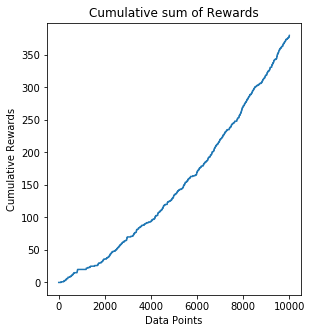

In [37]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.plot(cumsum_reward);
plt.xlabel("Data Points")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative sum of Rewards")

Here we can see that from the complete uncertainity,algorithm is improving to predict the best suggestion for given user. This is clearly shows that CTR(Click Through Rate) is increasing.

#### Play with this algorithm: shuffle the data and run multiple time with different hyperparameter "alpha" and compare the cumulative rewards.